In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install requests

    100% |################################| 92kB 2.8MB/s ta 0:00:01
    100% |################################| 61kB 5.0MB/s ta 0:00:01
    100% |################################| 153kB 5.7MB/s ta 0:00:01
    100% |################################| 143kB 6.0MB/s ta 0:00:01
    100% |################################| 143kB 6.8MB/s ta 0:00:01


In [149]:
import tensorflow as tf
import numpy as np

from utils import reset
from data import wider_face, transforms
from yolophem import models
from caps import utils

In [71]:
train, val, test = wider_face.load_data()

In [165]:
images, labels = next(train.batch(8))

In [166]:
t = transforms.AffineWarp(448, 448)
images_res, labels_res = t(images, labels)

In [178]:
image = images_res[5]
labels = labels_res[5]

In [181]:
labels_res

[array([[196, 106,  53,  48]]),
 array([[157,  30, 115, 106]]),
 array([[ 34, 128,   3,   4],
        [ 34, 138,   6,   9],
        [ 49, 123,   4,   8],
        [ 58, 151,   6,   8],
        [ 71, 145,   6,   9],
        [ 87, 127,   4,   7],
        [ 79, 155,   6,   9],
        [107, 162,   7,   8],
        [133, 154,   7,   9],
        [143, 172,   7,  11],
        [170, 163,   7,  11],
        [177, 170,   9,  12],
        [190, 169,   9,   9],
        [228, 191,   9,  10],
        [281, 186,  10,  12],
        [285, 130,   7,  14],
        [346, 196,  10,  17],
        [234, 181,   7,   9],
        [ 12, 128,   4,   8],
        [  1, 135,   4,   8],
        [  8, 125,   5,   9]]),
 array([[ 30, 235,  21,  23],
        [ 99, 250,  24,  28],
        [129, 200,  19,  17],
        [154, 183,  17,  23],
        [387, 247,  27,  26],
        [358, 256,  14,  28],
        [318, 224,  16,  20],
        [261, 161,  14,  19],
        [323, 202,  19,  21]]),
 array([[ 11, 118,  14,  18],
  

In [147]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

[ 58 279   5   6]
[ 24 279   2   4]
[ 47 265   6  12]
[ 59 259   2   3]
[439 266   6  10]
[432 284   7  10]
[420 267   5   9]
[413 273   6  10]
[403 267   6   9]
[393 280   5   8]
[392 273   5   6]
[362 279   6  10]
[355 276   5   9]
[360 271   3   6]
[374 278   4   6]
[430 319   6  10]
[256 276   3   5]
[145 185   4   7]


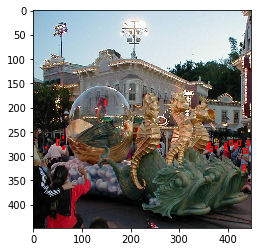

In [179]:
# Create figure and axes
_, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a Rectangle patch
for label in labels:
    print(label)
    x, y, width, height = label[:]
    rect = patches.Rectangle((x,y),width, height,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [133]:
reset()
models.adapted(models.config_v1)

Tensor("conv1/Relu:0", shape=(?, 221, 221, 256), dtype=float32)
Tensor("primaryCaps/outputs/mul:0", shape=(?, 221, 221, 32, 8), dtype=float32)
Tensor("convCaps1/routing/outputs:0", shape=(?, 109, 109, 16, 16), dtype=float32)
Tensor("convCaps2/routing/outputs:0", shape=(?, 53, 53, 16, 16), dtype=float32)
Tensor("convCaps3/routing/outputs:0", shape=(?, 25, 25, 8, 24), dtype=float32)
Tensor("convCaps4/routing/outputs:0", shape=(?, 11, 11, 8, 24), dtype=float32)
Tensor("convCaps5/routing/outputs:0", shape=(?, 9, 9, 3, 32), dtype=float32)
Tensor("convCaps6/routing/outputs:0", shape=(?, 7, 7, 3, 32), dtype=float32)


([<tf.Tensor 'X:0' shape=(?, 448, 448, 3) dtype=float32>,
  <tf.Tensor 'y:0' shape=(?, 5) dtype=int64>],
 (<tf.Tensor 'predictions_out:0' shape=(?, 147, 4) dtype=float32>,
  <tf.Tensor 'confidences_out:0' shape=(?, 147) dtype=float32>),
 <tf.Tensor 'loss/add_1:0' shape=() dtype=float32>)

In [137]:
reset()
[X, y], [predictions, confidences], loss = models.naive(models.config_v1, 4096)

Tensor("conv1/Relu:0", shape=(?, 221, 221, 256), dtype=float32)
Tensor("primaryCaps/outputs/mul:0", shape=(?, 221, 221, 32, 8), dtype=float32)
Tensor("convCaps1/routing/outputs:0", shape=(?, 109, 109, 16, 16), dtype=float32)
Tensor("convCaps2/routing/outputs:0", shape=(?, 53, 53, 16, 16), dtype=float32)
Tensor("convCaps3/routing/outputs:0", shape=(?, 25, 25, 8, 24), dtype=float32)
Tensor("convCaps4/routing/outputs:0", shape=(?, 11, 11, 8, 24), dtype=float32)
Tensor("convCaps5/routing/outputs:0", shape=(?, 9, 9, 3, 32), dtype=float32)
Tensor("convCaps6/routing/outputs:0", shape=(?, 7, 7, 3, 32), dtype=float32)
